# BranchPro: inference of R_t with negative binomial noise

The first part of the notebook includes a forward simulation of the incidence numbers for an example branching process model with negative binomial noise. The reproduction number profile is assumed to be a step function with only one jump.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd

num_timepoints = 30 # number of days for incidence data


## Parameterize example branching process model

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w
phi = 0.005

m = branchpro.NegBinBranchProModel(initial_r, serial_interval, phi)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

cases = m.simulate(parameters, times)
print(cases)

[ 100.    0.   60.   94.  108.  158.  174.  306.  371.  584.  759. 1170.
 1492. 1882. 3076. 3792.  876. 1124. 1221. 1027.  783.  662.  567.  493.
  405.  311.  278.  252.  211.  155.]


## Plot local incidence numbers

In [3]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Compute the posterior distribution using sampling class method

In [4]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
lam = 1

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

inference_new = branchpro.NegBinBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau=tau,
    phi=phi,
    alpha=a,
    beta=1/b,
    lam=lam)


Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.


/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_transformation.py:795: RuntimeWarning:

overflow encountered in exp



Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     444    0.0252   64      0.0461   20      0.0388   31       0:01.6
1     537    0.0428   16                                         0:01.9
2     1302   0.0427   128     0.0432   64      0.0416   64       0:04.7
3     4371   0.0915   512     0.0519   512     0.0877   512      0:15.5
20    56544  0.772    967     0.747    967     0.751    967      3:20.4
40    117924  0.74     975     0.751    975     0.735    975      6:57.9
60    179304  0.742    975     0.733    975     0.721555 975     10:36.2
80    240684  0.722    975     0.745    975     0.767    975     14:15.9
100   298624  0.756    972     0.753204 972     0.73     972     17:43.0
Halting: Maximum number of iterations (100) reached.
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
R_t7     0.20    0.00    0.20    

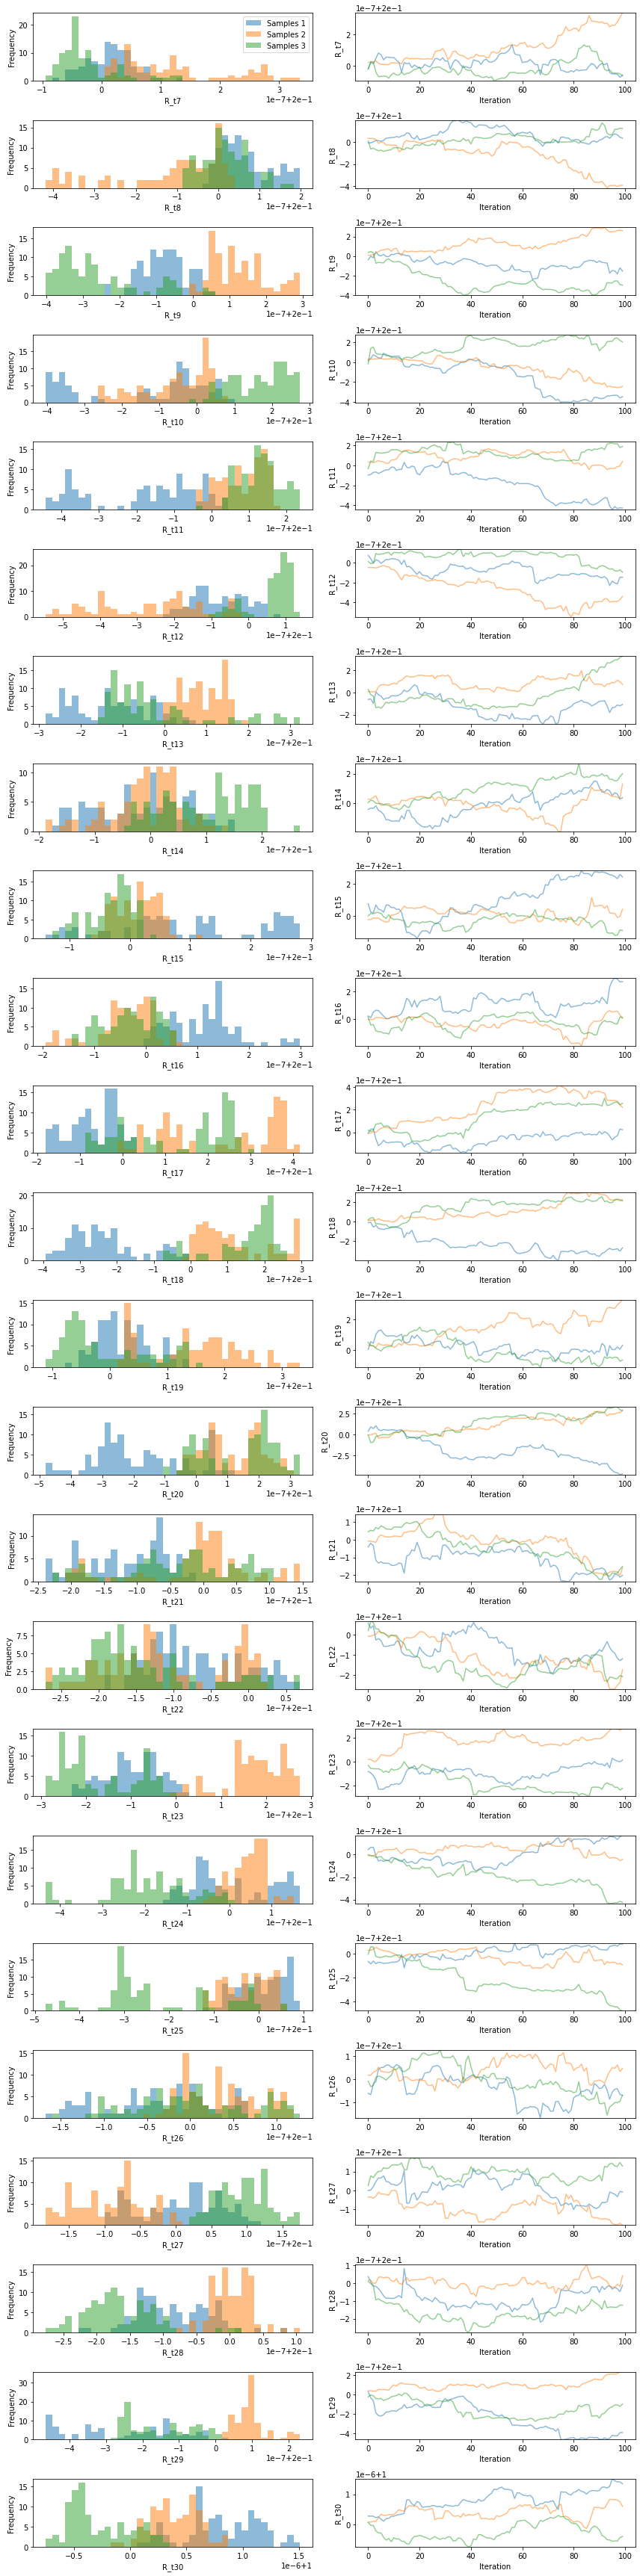

In [5]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference_new.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 50:, :-1]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [6]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [7]:
dLl = []
old_r_profile = [1]*(tau) + ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
    new_r_profile = old_r_profile.copy()
    new_r_profile[_] = old_r_profile[_] + 10**(-5)
    dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

inference_new_new = branchpro.NegBinBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau=tau,
    phi=phi + 10**(-15),
    alpha=a,
    beta=1/b,
    lam=lam)

dLl.append((inference_new_new.ll(old_r_profile)-inference_new.ll(old_r_profile))/10**(-15))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[436.5935223177075, 581.6513439640403, 758.5464976727961, 928.1148435547947, 1158.0581776797771, 1359.1726077720523, -2.566678449511528, -0.5156733095645905, -0.6045913323760033, -57.823699899017804, -113.52617293596266, -172.39446751773357, -225.0369172543287, -270.60804422944784, -325.40399115532637, -31.975470483303067, 4.217587411403656, 57.31822457164525, 40.20296037197113, 17.41077285259962, 36.3724771887064, 56.46082572638988, 43.86615473777055, 1396983.8619232178]
[436.597426513598, 581.6566625384368, 758.5535542387865, 928.1237514510665, 1158.0696046059752, 1359.1864871672233, -2.566082287284189, -0.5150438975324505, -0.6039178112205263, -57.82319143525456, -113.52582418106613, -172.3943194768799, -225.03692179023255, -270.6081818787361, -325.40430593948577, -31.95338076740154, 4.239833938749143, 57.340610803756135, 40.224127425110055, 17.430544743716382, 36.39150016744679, 56.479013022477375, 43.88300711269312, 992076.972215979]


In [26]:
output_optimisation = inference_new.run_optimisation()[0]
theta_hat, phi_hat = output_optimisation[:-1], output_optimisation[-1]

shape = []
rate = []
mean = []

i=0
for _, t in enumerate(range(R_t_start,num_timepoints)):
    shape.append( a + math.fsum(cases[(t-tau):(t+1)]) )
    sum_var = np.zeros_like(cases[(t-tau):(t+1)])
    for k_inx, k in enumerate(range(t-tau,t+1)):
        vec1 = cases[(k-1)::-1] # I_(k-1), ... , I_0
        vec2 = serial_interval[:k] # w_1, ... , w_k
        sum_var[k_inx] = math.fsum(np.multiply(vec1,vec2))  # vector of sum^k_{s=0} w_s I_{k-s}

    rate.append(np.sum(
        np.multiply(np.multiply(cases[(t-tau):(t+1)] + 1/phi_hat, np.square(sum_var)), np.reciprocal(np.square(theta_hat[_] * sum_var + 1/phi_hat)))))
    i += 1


# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

S_vector = np.reciprocal(np.multiply(np.array(shape)-1, np.reciprocal(np.square(theta_hat))) - np.array(rate))
S = np.diag(S_vector)

# q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta1.mean(),
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13      923832.9  923832.9   0:00.0
1     26      926094.2  926094.2   0:00.1
2     39      927427.6  927427.6   0:00.1
3     52      928306.2  928306.2   0:00.1
20    273     930871.5  930536.3   0:00.5
40    533     931774.6  931774.6   0:00.9
60    793     931890    931888     0:01.4
80    1053    931906.4  931906.4   0:01.8
100   1313    931911.2  931911.2   0:02.2
120   1573    931911.9  931911.9   0:02.7
140   1833    931912    931912     0:03.1
160   2093    931912    931912     0:03.5
180   2353    931912    931912     0:03.9
200   2613    931912    931912     0:04.4
207   2691    931912    931912     0:04.5
Halting: No significant change for 100 iterations.
[2.71933534 2.74244719 2.85036118 2.86310904 2.92770454 2.93541936
 2.94061367 2.96029747 2.96179719 2.55701497 2.17916055 1.79459117
 1.45848758 1.

In [27]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()